In [1]:
import torch
from torch import optim, nn
from torchvision import models, transforms
model = models.vgg16(pretrained=True)

c:\Users\Rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
import os

base_dir = 'images'  # Root folder containing category subfolders (e.g., tops/, jeans/)
output_file = 'image_samples.txt'

with open(output_file, 'w') as f:
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                relative_path = os.path.join(root, file).replace("\\", "/")
                f.write(relative_path + '\n')

print(f"✅ image_samples.txt generated with paths to {sum(1 for line in open(output_file))} images.")


✅ image_samples.txt generated with paths to 1525 images.


In [3]:
class FeatureExtractor(nn.Module):
  def __init__(self, model):
    super(FeatureExtractor, self).__init__()
		# Extract VGG-16 Feature Layers
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
		# Extract VGG-16 Average Pooling Layer
    self.pooling = model.avgpool
		# Convert the image into one-dimensional vector
    self.flatten = nn.Flatten()
		# Extract the first part of fully-connected layer from VGG16
    self.fc = model.classifier[0]
  
  def forward(self, x):
		# It will take the input 'x' until it returns the feature vector called 'out'
    out = self.features(x)
    out = self.pooling(out)
    out = self.flatten(out)
    out = self.fc(out) 
    return out 

# Initialize the model
model = models.vgg16(pretrained=True)
new_model = FeatureExtractor(model)

# Change the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)

In [4]:
from tqdm import tqdm
import numpy as np
import os
import cv2
# from google.colab.patches import cv2_imshow

# Transform the image, so it becomes readable with the model
transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.CenterCrop(512),
  transforms.Resize(448),
  transforms.ToTensor()                              
])

currentPath = os.getcwd()

with open('image_samples.txt') as f:
    lines = f.readlines()

# Will contain the feature
features = []
image_id = []
count = 0
for line in lines:
    folder = line.split("/")[-2]
    image_name = (line.split("/")[-1]).strip()
    joint = 'images' + '/'+ folder
    newJoint = os.path.join(currentPath, joint, image_name)
    count = count + 1
    if count%20 == 0:
        print(count)
    image_id.append(image_name)
    img = cv2.imread(newJoint)
    img = transform(img)
    
    img = img.reshape(1, 3, 448, 448)
    img = img.to(device)
   
    with torch.no_grad():
    
      feature = new_model(img)
   
    features.append(feature.cpu().detach().numpy().reshape(-1))

# Convert to NumPy Array
features = np.array(features)
print(features.shape)
print(features[0])

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
(1525, 4096)
[ 0.15151572 -0.05081118  0.55109787 ... -0.398967    0.1723454
 -0.3280705 ]


In [5]:
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

# ✅ Assume features is already a NumPy array with shape (num_samples, feature_dim)
num_samples = features.shape[0]
print(f"✅ Total image features extracted: {num_samples}")

# Choose safe bounds for number of clusters
min_num_clusters = 2
max_num_clusters = min(50, num_samples - 1)  # silhouette score requires n_clusters <= n_samples - 1

# To store scores
silhouette_scores = []
davies_bouldin_scores = []

print("k \t Silhouette \t\t DB")
for num_clusters in range(min_num_clusters, max_num_clusters + 1):
    model = KMeans(n_clusters=num_clusters, random_state=42)
    model.fit(features)
    labels = model.labels_

    # Scores
    s = metrics.silhouette_score(features, labels, metric='euclidean')
    d = metrics.davies_bouldin_score(features, labels)

    silhouette_scores.append(s)
    davies_bouldin_scores.append(d)

    print(f"{num_clusters} \t {s:.4f} \t\t {d:.4f}")


✅ Total image features extracted: 1525
k 	 Silhouette 		 DB
2 	 0.2874 		 2.5281
3 	 0.1322 		 2.5700
4 	 0.1184 		 2.8630
5 	 0.1228 		 2.7770
6 	 0.1353 		 2.6503
7 	 0.1191 		 2.6277
8 	 0.1220 		 2.5156
9 	 0.1200 		 2.5658
10 	 0.0409 		 2.6760
11 	 0.0435 		 2.5850
12 	 0.0451 		 2.5480
13 	 0.0506 		 2.4703
14 	 0.0444 		 2.4221
15 	 0.0507 		 2.5330
16 	 0.0535 		 2.4442
17 	 0.0474 		 2.4171
18 	 0.0479 		 2.3576
19 	 0.0429 		 2.3640
20 	 0.0441 		 2.3556
21 	 0.0987 		 2.3871
22 	 0.0919 		 2.4073
23 	 0.0916 		 2.3195
24 	 0.0953 		 2.2933
25 	 0.0967 		 2.2697
26 	 0.0982 		 2.2487
27 	 0.0991 		 2.2144
28 	 0.0995 		 2.1754
29 	 0.0702 		 2.2180
30 	 0.0707 		 2.2346
31 	 0.0649 		 2.2775
32 	 0.0746 		 2.2508
33 	 0.0443 		 2.2306
34 	 0.0454 		 2.2022
35 	 0.0443 		 2.2701
36 	 0.0454 		 2.2570
37 	 0.0429 		 2.3039
38 	 0.0437 		 2.2985
39 	 0.0443 		 2.2801
40 	 0.0445 		 2.2638
41 	 0.0461 		 2.2466
42 	 0.0459 		 2.2019
43 	 0.0454 		 2.2042
44 	 0.0459 		 2.2421
45

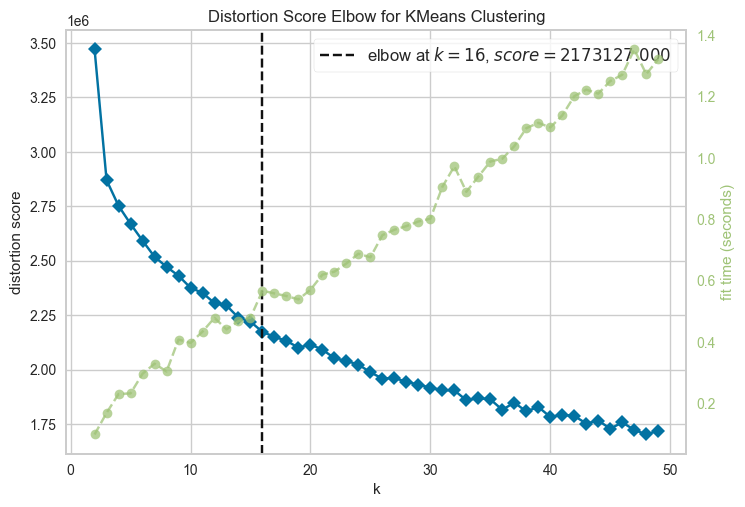

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(min_num_clusters, max_num_clusters))

visualizer.fit(features)    # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [7]:
best_num_clusters = 34
best_num_clusters_index = best_num_clusters - min_num_clusters  

print("Optimal no. of clusters is", best_num_clusters, "by Elbow Method")


# best_num_clusters_index = np.argmax(silhouette_scores)
# best_num_clusters = min_num_clusters + best_num_clusters_index
# print("Silhouette Scores")
# for i in range(len(silhouette_scores)):
#   print(i, ":", silhouette_scores[i])

# print("Optimal no. of clusters is", best_num_clusters, "with Silhouette score of", silhouette_scores[best_num_clusters_index])


# best_num_clusters_index = np.argmax(davies_bouldin_scores)
# best_num_clusters = min_num_clusters + best_num_clusters_index 
# # print("Silhouette Scores")
# # for i in range(len(silhouette_scores)):
# #   print(i, ":", silhouette_scores[i])

# print("Optimal no. of clusters is", best_num_clusters, "with David Bouldin score of", davies_bouldin_scores[best_num_clusters_index])

Optimal no. of clusters is 34 by Elbow Method


In [10]:
for k in range(0, num_clusters):
    print(f"\nCluster {k}")
    cluster_indices = np.where(labels == k)[0]
    numImages = len(cluster_indices)
    print(numImages)
    numRows = int(numImages / 10) + 1
    numCols = 10
    fig = plt.figure(k, figsize=(numCols * 2.0, numRows * 2.0))

    for num, idx in enumerate(cluster_indices):
        if idx >= len(images):  # safeguard
            print(f"Skipping idx {idx} - out of image range.")
            continue

        imagePath = os.path.join(path, images[idx])
        try:
            img = image.load_img(imagePath)
            plt.subplot(numRows, numCols, num + 1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(img)
        except Exception as e:
            print(f"Error loading {imagePath}: {e}")
            continue

    plt.tight_layout()
    plt.show()


Cluster 0
39
Skipping idx 71 - out of image range.
Skipping idx 270 - out of image range.
Skipping idx 271 - out of image range.
Skipping idx 379 - out of image range.
Skipping idx 397 - out of image range.
Skipping idx 403 - out of image range.
Skipping idx 404 - out of image range.
Skipping idx 405 - out of image range.
Skipping idx 406 - out of image range.
Skipping idx 408 - out of image range.
Skipping idx 419 - out of image range.
Skipping idx 420 - out of image range.
Skipping idx 566 - out of image range.
Skipping idx 567 - out of image range.
Skipping idx 568 - out of image range.
Skipping idx 573 - out of image range.
Skipping idx 574 - out of image range.
Skipping idx 584 - out of image range.
Skipping idx 585 - out of image range.
Skipping idx 588 - out of image range.
Skipping idx 589 - out of image range.
Skipping idx 592 - out of image range.
Skipping idx 607 - out of image range.
Skipping idx 677 - out of image range.
Skipping idx 678 - out of image range.
Skipping idx

<Figure size 2000x800 with 0 Axes>


Cluster 1
102
Skipping idx 85 - out of image range.
Skipping idx 88 - out of image range.
Skipping idx 90 - out of image range.
Skipping idx 91 - out of image range.
Skipping idx 92 - out of image range.
Skipping idx 93 - out of image range.
Skipping idx 96 - out of image range.
Skipping idx 97 - out of image range.
Skipping idx 117 - out of image range.
Skipping idx 240 - out of image range.
Skipping idx 276 - out of image range.
Skipping idx 311 - out of image range.
Skipping idx 367 - out of image range.
Skipping idx 369 - out of image range.
Skipping idx 373 - out of image range.
Skipping idx 392 - out of image range.
Skipping idx 393 - out of image range.
Skipping idx 407 - out of image range.
Skipping idx 424 - out of image range.
Skipping idx 425 - out of image range.
Skipping idx 432 - out of image range.
Skipping idx 433 - out of image range.
Skipping idx 444 - out of image range.
Skipping idx 445 - out of image range.
Skipping idx 446 - out of image range.
Skipping idx 449 -

<Figure size 2000x2200 with 0 Axes>


Cluster 2
15
Skipping idx 241 - out of image range.
Skipping idx 313 - out of image range.
Skipping idx 314 - out of image range.
Skipping idx 315 - out of image range.
Skipping idx 624 - out of image range.
Skipping idx 690 - out of image range.
Skipping idx 691 - out of image range.
Skipping idx 989 - out of image range.
Skipping idx 1006 - out of image range.
Skipping idx 1012 - out of image range.
Skipping idx 1022 - out of image range.
Skipping idx 1174 - out of image range.
Skipping idx 1312 - out of image range.
Skipping idx 1460 - out of image range.
Skipping idx 1491 - out of image range.


<Figure size 2000x400 with 0 Axes>


Cluster 3
227
Skipping idx 2 - out of image range.
Skipping idx 6 - out of image range.
Skipping idx 15 - out of image range.
Skipping idx 41 - out of image range.
Skipping idx 44 - out of image range.
Skipping idx 45 - out of image range.
Skipping idx 64 - out of image range.
Skipping idx 78 - out of image range.
Skipping idx 82 - out of image range.
Skipping idx 83 - out of image range.
Skipping idx 134 - out of image range.
Skipping idx 170 - out of image range.
Skipping idx 172 - out of image range.
Skipping idx 188 - out of image range.
Skipping idx 190 - out of image range.
Skipping idx 191 - out of image range.
Skipping idx 192 - out of image range.
Skipping idx 193 - out of image range.
Skipping idx 194 - out of image range.
Skipping idx 195 - out of image range.
Skipping idx 196 - out of image range.
Skipping idx 197 - out of image range.
Skipping idx 203 - out of image range.
Skipping idx 211 - out of image range.
Skipping idx 223 - out of image range.
Skipping idx 225 - out

<Figure size 2000x4600 with 0 Axes>


Cluster 4
48
Skipping idx 126 - out of image range.
Skipping idx 222 - out of image range.
Skipping idx 232 - out of image range.
Skipping idx 391 - out of image range.
Skipping idx 629 - out of image range.
Skipping idx 633 - out of image range.
Skipping idx 654 - out of image range.
Skipping idx 685 - out of image range.
Skipping idx 686 - out of image range.
Skipping idx 733 - out of image range.
Skipping idx 737 - out of image range.
Skipping idx 742 - out of image range.
Skipping idx 745 - out of image range.
Skipping idx 902 - out of image range.
Skipping idx 904 - out of image range.
Skipping idx 991 - out of image range.
Skipping idx 1009 - out of image range.
Skipping idx 1032 - out of image range.
Skipping idx 1034 - out of image range.
Skipping idx 1035 - out of image range.
Skipping idx 1036 - out of image range.
Skipping idx 1067 - out of image range.
Skipping idx 1077 - out of image range.
Skipping idx 1093 - out of image range.
Skipping idx 1113 - out of image range.
Sk

<Figure size 2000x1000 with 0 Axes>


Cluster 5
79
Skipping idx 16 - out of image range.
Skipping idx 17 - out of image range.
Skipping idx 18 - out of image range.
Skipping idx 19 - out of image range.
Skipping idx 21 - out of image range.
Skipping idx 22 - out of image range.
Skipping idx 26 - out of image range.
Skipping idx 35 - out of image range.
Skipping idx 36 - out of image range.
Skipping idx 69 - out of image range.
Skipping idx 72 - out of image range.
Skipping idx 118 - out of image range.
Skipping idx 122 - out of image range.
Skipping idx 146 - out of image range.
Skipping idx 186 - out of image range.
Skipping idx 208 - out of image range.
Skipping idx 233 - out of image range.
Skipping idx 287 - out of image range.
Skipping idx 372 - out of image range.
Skipping idx 378 - out of image range.
Skipping idx 380 - out of image range.
Skipping idx 384 - out of image range.
Skipping idx 394 - out of image range.
Skipping idx 395 - out of image range.
Skipping idx 396 - out of image range.
Skipping idx 398 - out

<Figure size 2000x1600 with 0 Axes>


Cluster 6
26
Skipping idx 102 - out of image range.
Skipping idx 104 - out of image range.
Skipping idx 236 - out of image range.
Skipping idx 317 - out of image range.
Skipping idx 596 - out of image range.
Skipping idx 655 - out of image range.
Skipping idx 656 - out of image range.
Skipping idx 657 - out of image range.
Skipping idx 720 - out of image range.
Skipping idx 750 - out of image range.
Skipping idx 789 - out of image range.
Skipping idx 808 - out of image range.
Skipping idx 809 - out of image range.
Skipping idx 892 - out of image range.
Skipping idx 893 - out of image range.
Skipping idx 894 - out of image range.
Skipping idx 895 - out of image range.
Skipping idx 896 - out of image range.
Skipping idx 897 - out of image range.
Skipping idx 924 - out of image range.
Skipping idx 1071 - out of image range.
Skipping idx 1361 - out of image range.
Skipping idx 1452 - out of image range.
Skipping idx 1466 - out of image range.
Skipping idx 1467 - out of image range.
Skippi

<Figure size 2000x600 with 0 Axes>


Cluster 7
87
Skipping idx 55 - out of image range.
Skipping idx 101 - out of image range.
Skipping idx 201 - out of image range.
Skipping idx 226 - out of image range.
Skipping idx 316 - out of image range.
Skipping idx 436 - out of image range.
Skipping idx 437 - out of image range.
Skipping idx 460 - out of image range.
Skipping idx 469 - out of image range.
Skipping idx 470 - out of image range.
Skipping idx 477 - out of image range.
Skipping idx 492 - out of image range.
Skipping idx 503 - out of image range.
Skipping idx 669 - out of image range.
Skipping idx 670 - out of image range.
Skipping idx 693 - out of image range.
Skipping idx 696 - out of image range.
Skipping idx 729 - out of image range.
Skipping idx 731 - out of image range.
Skipping idx 734 - out of image range.
Skipping idx 736 - out of image range.
Skipping idx 759 - out of image range.
Skipping idx 760 - out of image range.
Skipping idx 761 - out of image range.
Skipping idx 762 - out of image range.
Skipping idx

<Figure size 2000x1800 with 0 Axes>


Cluster 8
23
Skipping idx 252 - out of image range.
Skipping idx 428 - out of image range.
Skipping idx 468 - out of image range.
Skipping idx 474 - out of image range.
Skipping idx 475 - out of image range.
Skipping idx 478 - out of image range.
Skipping idx 480 - out of image range.
Skipping idx 533 - out of image range.
Skipping idx 536 - out of image range.
Skipping idx 623 - out of image range.
Skipping idx 671 - out of image range.
Skipping idx 718 - out of image range.
Skipping idx 726 - out of image range.
Skipping idx 752 - out of image range.
Skipping idx 871 - out of image range.
Skipping idx 1153 - out of image range.
Skipping idx 1209 - out of image range.
Skipping idx 1303 - out of image range.
Skipping idx 1306 - out of image range.
Skipping idx 1311 - out of image range.
Skipping idx 1313 - out of image range.
Skipping idx 1337 - out of image range.
Skipping idx 1369 - out of image range.


<Figure size 2000x600 with 0 Axes>


Cluster 9
23
Skipping idx 133 - out of image range.
Skipping idx 163 - out of image range.
Skipping idx 167 - out of image range.
Skipping idx 307 - out of image range.
Skipping idx 346 - out of image range.
Skipping idx 347 - out of image range.
Skipping idx 348 - out of image range.
Skipping idx 349 - out of image range.
Skipping idx 498 - out of image range.
Skipping idx 501 - out of image range.
Skipping idx 504 - out of image range.
Skipping idx 505 - out of image range.
Skipping idx 520 - out of image range.
Skipping idx 565 - out of image range.
Skipping idx 658 - out of image range.
Skipping idx 747 - out of image range.
Skipping idx 842 - out of image range.
Skipping idx 955 - out of image range.
Skipping idx 961 - out of image range.
Skipping idx 1265 - out of image range.
Skipping idx 1368 - out of image range.
Skipping idx 1392 - out of image range.
Skipping idx 1523 - out of image range.


<Figure size 2000x600 with 0 Axes>


Cluster 10
40
Skipping idx 106 - out of image range.
Skipping idx 108 - out of image range.
Skipping idx 166 - out of image range.
Skipping idx 169 - out of image range.
Skipping idx 308 - out of image range.
Skipping idx 340 - out of image range.
Skipping idx 341 - out of image range.
Skipping idx 343 - out of image range.
Skipping idx 350 - out of image range.
Skipping idx 455 - out of image range.
Skipping idx 487 - out of image range.
Skipping idx 489 - out of image range.
Skipping idx 494 - out of image range.
Skipping idx 497 - out of image range.
Skipping idx 509 - out of image range.
Skipping idx 512 - out of image range.
Skipping idx 513 - out of image range.
Skipping idx 522 - out of image range.
Skipping idx 535 - out of image range.
Skipping idx 540 - out of image range.
Skipping idx 541 - out of image range.
Skipping idx 687 - out of image range.
Skipping idx 719 - out of image range.
Skipping idx 728 - out of image range.
Skipping idx 758 - out of image range.
Skipping i

<Figure size 2000x1000 with 0 Axes>


Cluster 11
3
Skipping idx 619 - out of image range.
Skipping idx 620 - out of image range.
Skipping idx 660 - out of image range.


<Figure size 2000x200 with 0 Axes>


Cluster 12
45
Skipping idx 52 - out of image range.
Skipping idx 77 - out of image range.
Skipping idx 79 - out of image range.
Skipping idx 80 - out of image range.
Skipping idx 128 - out of image range.
Skipping idx 129 - out of image range.
Skipping idx 142 - out of image range.
Skipping idx 200 - out of image range.
Skipping idx 217 - out of image range.
Skipping idx 218 - out of image range.
Skipping idx 219 - out of image range.
Skipping idx 330 - out of image range.
Skipping idx 342 - out of image range.
Skipping idx 344 - out of image range.
Skipping idx 345 - out of image range.
Skipping idx 352 - out of image range.
Skipping idx 355 - out of image range.
Skipping idx 356 - out of image range.
Skipping idx 360 - out of image range.
Skipping idx 362 - out of image range.
Skipping idx 387 - out of image range.
Skipping idx 388 - out of image range.
Skipping idx 389 - out of image range.
Skipping idx 543 - out of image range.
Skipping idx 622 - out of image range.
Skipping idx 6

<Figure size 2000x1000 with 0 Axes>


Cluster 13
101
Skipping idx 3 - out of image range.
Skipping idx 5 - out of image range.
Skipping idx 46 - out of image range.
Skipping idx 47 - out of image range.
Skipping idx 49 - out of image range.
Skipping idx 50 - out of image range.
Skipping idx 57 - out of image range.
Skipping idx 58 - out of image range.
Skipping idx 60 - out of image range.
Skipping idx 61 - out of image range.
Skipping idx 62 - out of image range.
Skipping idx 63 - out of image range.
Skipping idx 75 - out of image range.
Skipping idx 89 - out of image range.
Skipping idx 111 - out of image range.
Skipping idx 112 - out of image range.
Skipping idx 113 - out of image range.
Skipping idx 121 - out of image range.
Skipping idx 130 - out of image range.
Skipping idx 135 - out of image range.
Skipping idx 138 - out of image range.
Skipping idx 158 - out of image range.
Skipping idx 159 - out of image range.
Skipping idx 161 - out of image range.
Skipping idx 198 - out of image range.
Skipping idx 213 - out of

<Figure size 2000x2200 with 0 Axes>


Cluster 14
5
Skipping idx 28 - out of image range.
Skipping idx 29 - out of image range.
Skipping idx 30 - out of image range.
Skipping idx 136 - out of image range.
Skipping idx 137 - out of image range.


<Figure size 2000x200 with 0 Axes>


Cluster 15
22
Skipping idx 110 - out of image range.
Skipping idx 145 - out of image range.
Skipping idx 442 - out of image range.
Skipping idx 488 - out of image range.
Skipping idx 511 - out of image range.
Skipping idx 515 - out of image range.
Skipping idx 518 - out of image range.
Skipping idx 521 - out of image range.
Skipping idx 524 - out of image range.
Skipping idx 605 - out of image range.
Skipping idx 746 - out of image range.
Skipping idx 751 - out of image range.
Skipping idx 753 - out of image range.
Skipping idx 756 - out of image range.
Skipping idx 800 - out of image range.
Skipping idx 869 - out of image range.
Skipping idx 870 - out of image range.
Skipping idx 946 - out of image range.
Skipping idx 1055 - out of image range.
Skipping idx 1094 - out of image range.
Skipping idx 1240 - out of image range.
Skipping idx 1241 - out of image range.


<Figure size 2000x600 with 0 Axes>


Cluster 16
75
Skipping idx 11 - out of image range.
Skipping idx 12 - out of image range.
Skipping idx 13 - out of image range.
Skipping idx 14 - out of image range.
Skipping idx 76 - out of image range.
Skipping idx 84 - out of image range.
Skipping idx 94 - out of image range.
Skipping idx 124 - out of image range.
Skipping idx 125 - out of image range.
Skipping idx 202 - out of image range.
Skipping idx 205 - out of image range.
Skipping idx 212 - out of image range.
Skipping idx 227 - out of image range.
Skipping idx 312 - out of image range.
Skipping idx 383 - out of image range.
Skipping idx 385 - out of image range.
Skipping idx 447 - out of image range.
Skipping idx 448 - out of image range.
Skipping idx 517 - out of image range.
Skipping idx 561 - out of image range.
Skipping idx 569 - out of image range.
Skipping idx 570 - out of image range.
Skipping idx 571 - out of image range.
Skipping idx 600 - out of image range.
Skipping idx 630 - out of image range.
Skipping idx 688 

<Figure size 2000x1600 with 0 Axes>


Cluster 17
18
Skipping idx 87 - out of image range.
Skipping idx 107 - out of image range.
Skipping idx 151 - out of image range.
Skipping idx 152 - out of image range.
Skipping idx 153 - out of image range.
Skipping idx 155 - out of image range.
Skipping idx 157 - out of image range.
Skipping idx 523 - out of image range.
Skipping idx 836 - out of image range.
Skipping idx 845 - out of image range.
Skipping idx 944 - out of image range.
Skipping idx 953 - out of image range.
Skipping idx 956 - out of image range.
Skipping idx 1108 - out of image range.
Skipping idx 1228 - out of image range.
Skipping idx 1301 - out of image range.
Skipping idx 1314 - out of image range.
Skipping idx 1367 - out of image range.


<Figure size 2000x400 with 0 Axes>


Cluster 18
21
Skipping idx 38 - out of image range.
Skipping idx 318 - out of image range.
Skipping idx 319 - out of image range.
Skipping idx 320 - out of image range.
Skipping idx 321 - out of image range.
Skipping idx 323 - out of image range.
Skipping idx 411 - out of image range.
Skipping idx 412 - out of image range.
Skipping idx 458 - out of image range.
Skipping idx 563 - out of image range.
Skipping idx 580 - out of image range.
Skipping idx 628 - out of image range.
Skipping idx 738 - out of image range.
Skipping idx 812 - out of image range.
Skipping idx 829 - out of image range.
Skipping idx 928 - out of image range.
Skipping idx 1091 - out of image range.
Skipping idx 1205 - out of image range.
Skipping idx 1206 - out of image range.
Skipping idx 1459 - out of image range.
Skipping idx 1492 - out of image range.


<Figure size 2000x600 with 0 Axes>


Cluster 19
12
Skipping idx 148 - out of image range.
Skipping idx 366 - out of image range.
Skipping idx 1007 - out of image range.
Skipping idx 1008 - out of image range.
Skipping idx 1010 - out of image range.
Skipping idx 1014 - out of image range.
Skipping idx 1016 - out of image range.
Skipping idx 1244 - out of image range.
Skipping idx 1246 - out of image range.
Skipping idx 1247 - out of image range.
Skipping idx 1275 - out of image range.
Skipping idx 1510 - out of image range.


<Figure size 2000x400 with 0 Axes>


Cluster 20
59
Skipping idx 8 - out of image range.
Skipping idx 37 - out of image range.
Skipping idx 48 - out of image range.
Skipping idx 67 - out of image range.
Skipping idx 68 - out of image range.
Skipping idx 73 - out of image range.
Skipping idx 74 - out of image range.
Skipping idx 119 - out of image range.
Skipping idx 123 - out of image range.
Skipping idx 132 - out of image range.
Skipping idx 143 - out of image range.
Skipping idx 210 - out of image range.
Skipping idx 259 - out of image range.
Skipping idx 277 - out of image range.
Skipping idx 280 - out of image range.
Skipping idx 283 - out of image range.
Skipping idx 309 - out of image range.
Skipping idx 322 - out of image range.
Skipping idx 542 - out of image range.
Skipping idx 599 - out of image range.
Skipping idx 650 - out of image range.
Skipping idx 652 - out of image range.
Skipping idx 667 - out of image range.
Skipping idx 700 - out of image range.
Skipping idx 703 - out of image range.
Skipping idx 704 -

<Figure size 2000x1200 with 0 Axes>


Cluster 21
17
Skipping idx 243 - out of image range.
Skipping idx 244 - out of image range.
Skipping idx 434 - out of image range.
Skipping idx 439 - out of image range.
Skipping idx 564 - out of image range.
Skipping idx 735 - out of image range.
Skipping idx 861 - out of image range.
Skipping idx 862 - out of image range.
Skipping idx 863 - out of image range.
Skipping idx 864 - out of image range.
Skipping idx 865 - out of image range.
Skipping idx 931 - out of image range.
Skipping idx 994 - out of image range.
Skipping idx 996 - out of image range.
Skipping idx 997 - out of image range.
Skipping idx 998 - out of image range.
Skipping idx 1000 - out of image range.


<Figure size 2000x400 with 0 Axes>


Cluster 22
13
Skipping idx 484 - out of image range.
Skipping idx 496 - out of image range.
Skipping idx 508 - out of image range.
Skipping idx 516 - out of image range.
Skipping idx 519 - out of image range.
Skipping idx 958 - out of image range.
Skipping idx 999 - out of image range.
Skipping idx 1154 - out of image range.
Skipping idx 1219 - out of image range.
Skipping idx 1271 - out of image range.
Skipping idx 1272 - out of image range.
Skipping idx 1323 - out of image range.
Skipping idx 1450 - out of image range.


<Figure size 2000x400 with 0 Axes>


Cluster 23
148
Skipping idx 0 - out of image range.
Skipping idx 1 - out of image range.
Skipping idx 4 - out of image range.
Skipping idx 10 - out of image range.
Skipping idx 31 - out of image range.
Skipping idx 32 - out of image range.
Skipping idx 34 - out of image range.
Skipping idx 39 - out of image range.
Skipping idx 40 - out of image range.
Skipping idx 42 - out of image range.
Skipping idx 43 - out of image range.
Skipping idx 51 - out of image range.
Skipping idx 59 - out of image range.
Skipping idx 81 - out of image range.
Skipping idx 95 - out of image range.
Skipping idx 116 - out of image range.
Skipping idx 120 - out of image range.
Skipping idx 131 - out of image range.
Skipping idx 171 - out of image range.
Skipping idx 184 - out of image range.
Skipping idx 187 - out of image range.
Skipping idx 189 - out of image range.
Skipping idx 204 - out of image range.
Skipping idx 214 - out of image range.
Skipping idx 224 - out of image range.
Skipping idx 228 - out of i

<Figure size 2000x3000 with 0 Axes>


Cluster 24
1
Skipping idx 723 - out of image range.


<Figure size 2000x200 with 0 Axes>


Cluster 25
27
Skipping idx 242 - out of image range.
Skipping idx 251 - out of image range.
Skipping idx 253 - out of image range.
Skipping idx 255 - out of image range.
Skipping idx 264 - out of image range.
Skipping idx 265 - out of image range.
Skipping idx 386 - out of image range.
Skipping idx 575 - out of image range.
Skipping idx 576 - out of image range.
Skipping idx 577 - out of image range.
Skipping idx 626 - out of image range.
Skipping idx 631 - out of image range.
Skipping idx 648 - out of image range.
Skipping idx 788 - out of image range.
Skipping idx 790 - out of image range.
Skipping idx 792 - out of image range.
Skipping idx 793 - out of image range.
Skipping idx 795 - out of image range.
Skipping idx 1030 - out of image range.
Skipping idx 1031 - out of image range.
Skipping idx 1039 - out of image range.
Skipping idx 1072 - out of image range.
Skipping idx 1239 - out of image range.
Skipping idx 1291 - out of image range.
Skipping idx 1449 - out of image range.
Ski

<Figure size 2000x600 with 0 Axes>


Cluster 26
71
Skipping idx 54 - out of image range.
Skipping idx 127 - out of image range.
Skipping idx 160 - out of image range.
Skipping idx 162 - out of image range.
Skipping idx 165 - out of image range.
Skipping idx 238 - out of image range.
Skipping idx 263 - out of image range.
Skipping idx 267 - out of image range.
Skipping idx 298 - out of image range.
Skipping idx 365 - out of image range.
Skipping idx 409 - out of image range.
Skipping idx 479 - out of image range.
Skipping idx 502 - out of image range.
Skipping idx 537 - out of image range.
Skipping idx 583 - out of image range.
Skipping idx 590 - out of image range.
Skipping idx 603 - out of image range.
Skipping idx 632 - out of image range.
Skipping idx 641 - out of image range.
Skipping idx 645 - out of image range.
Skipping idx 646 - out of image range.
Skipping idx 682 - out of image range.
Skipping idx 749 - out of image range.
Skipping idx 755 - out of image range.
Skipping idx 801 - out of image range.
Skipping id

<Figure size 2000x1600 with 0 Axes>


Cluster 27
3
Skipping idx 1309 - out of image range.
Skipping idx 1343 - out of image range.
Skipping idx 1350 - out of image range.


<Figure size 2000x200 with 0 Axes>


Cluster 28
3
Skipping idx 139 - out of image range.
Skipping idx 140 - out of image range.
Skipping idx 141 - out of image range.


<Figure size 2000x200 with 0 Axes>


Cluster 29
50
Skipping idx 98 - out of image range.
Skipping idx 99 - out of image range.
Skipping idx 100 - out of image range.
Skipping idx 103 - out of image range.
Skipping idx 105 - out of image range.
Skipping idx 164 - out of image range.
Skipping idx 168 - out of image range.
Skipping idx 199 - out of image range.
Skipping idx 249 - out of image range.
Skipping idx 250 - out of image range.
Skipping idx 254 - out of image range.
Skipping idx 256 - out of image range.
Skipping idx 257 - out of image range.
Skipping idx 329 - out of image range.
Skipping idx 422 - out of image range.
Skipping idx 440 - out of image range.
Skipping idx 441 - out of image range.
Skipping idx 454 - out of image range.
Skipping idx 582 - out of image range.
Skipping idx 587 - out of image range.
Skipping idx 593 - out of image range.
Skipping idx 597 - out of image range.
Skipping idx 598 - out of image range.
Skipping idx 716 - out of image range.
Skipping idx 717 - out of image range.
Skipping idx

<Figure size 2000x1200 with 0 Axes>


Cluster 30
37
Skipping idx 86 - out of image range.
Skipping idx 109 - out of image range.
Skipping idx 149 - out of image range.
Skipping idx 150 - out of image range.
Skipping idx 154 - out of image range.
Skipping idx 156 - out of image range.
Skipping idx 339 - out of image range.
Skipping idx 363 - out of image range.
Skipping idx 368 - out of image range.
Skipping idx 456 - out of image range.
Skipping idx 499 - out of image range.
Skipping idx 510 - out of image range.
Skipping idx 572 - out of image range.
Skipping idx 634 - out of image range.
Skipping idx 673 - out of image range.
Skipping idx 692 - out of image range.
Skipping idx 715 - out of image range.
Skipping idx 838 - out of image range.
Skipping idx 859 - out of image range.
Skipping idx 988 - out of image range.
Skipping idx 1059 - out of image range.
Skipping idx 1092 - out of image range.
Skipping idx 1100 - out of image range.
Skipping idx 1172 - out of image range.
Skipping idx 1177 - out of image range.
Skippi

<Figure size 2000x800 with 0 Axes>


Cluster 31
56
Skipping idx 20 - out of image range.
Skipping idx 23 - out of image range.
Skipping idx 24 - out of image range.
Skipping idx 25 - out of image range.
Skipping idx 33 - out of image range.
Skipping idx 56 - out of image range.
Skipping idx 70 - out of image range.
Skipping idx 114 - out of image range.
Skipping idx 115 - out of image range.
Skipping idx 144 - out of image range.
Skipping idx 147 - out of image range.
Skipping idx 173 - out of image range.
Skipping idx 174 - out of image range.
Skipping idx 175 - out of image range.
Skipping idx 176 - out of image range.
Skipping idx 177 - out of image range.
Skipping idx 178 - out of image range.
Skipping idx 179 - out of image range.
Skipping idx 180 - out of image range.
Skipping idx 181 - out of image range.
Skipping idx 182 - out of image range.
Skipping idx 183 - out of image range.
Skipping idx 185 - out of image range.
Skipping idx 206 - out of image range.
Skipping idx 207 - out of image range.
Skipping idx 209 

<Figure size 2000x1200 with 0 Axes>


Cluster 32
9
Skipping idx 310 - out of image range.
Skipping idx 457 - out of image range.
Skipping idx 625 - out of image range.
Skipping idx 663 - out of image range.
Skipping idx 1029 - out of image range.
Skipping idx 1057 - out of image range.
Skipping idx 1102 - out of image range.
Skipping idx 1252 - out of image range.
Skipping idx 1338 - out of image range.


<Figure size 2000x200 with 0 Axes>


Cluster 33
20
Skipping idx 7 - out of image range.
Skipping idx 9 - out of image range.
Skipping idx 27 - out of image range.
Skipping idx 53 - out of image range.
Skipping idx 65 - out of image range.
Skipping idx 66 - out of image range.
Skipping idx 289 - out of image range.
Skipping idx 290 - out of image range.
Skipping idx 291 - out of image range.
Skipping idx 292 - out of image range.
Skipping idx 659 - out of image range.
Skipping idx 689 - out of image range.
Skipping idx 1098 - out of image range.
Skipping idx 1099 - out of image range.
Skipping idx 1173 - out of image range.
Skipping idx 1184 - out of image range.
Skipping idx 1212 - out of image range.
Skipping idx 1277 - out of image range.
Skipping idx 1422 - out of image range.
Skipping idx 1485 - out of image range.


<Figure size 2000x600 with 0 Axes>

# Using Pre-trained ResNet

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import applications
from sklearn.metrics import pairwise_distances
import requests
from PIL import Image, ImageFile
import pickle
from datetime import datetime
ImageFile.LOAD_TRUNCATED_IMAGES = True
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display, Image


In [12]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from datetime import datetime
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set parameters
img_width, img_height = 224, 224
train_data_dir = r"C:\Users\Rohit\Downloads\Fashion-Recommendation-using-ML-main\Fashion-Recommendation-using-ML-main\images"
nb_train_samples = 801
batch_size = 1

def extract_features():
    Itemcodes = []
    
    # Load images
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = ResNet50(include_top=False, weights='imagenet')

    # Generate batches
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    # Extract file names without extension
    for i in generator.filenames:
        Itemcodes.append(os.path.basename(i).split('.')[0])

    # Predict features
    extracted_features = model.predict(generator, steps=nb_train_samples // batch_size)
    print("Extracted features shape (before reshape):", extracted_features.shape)

    # Reshape to 2D
    extracted_features = extracted_features.reshape((extracted_features.shape[0], -1))
    print("Extracted features shape (after reshape):", extracted_features.shape)

    # Save features and labels
    np.save('./x.npy', extracted_features)
    np.save('./x_ids.npy', np.array(Itemcodes))

# Run and log time
a = datetime.now()
extract_features()
print("✅ Feature extraction completed in:", datetime.now() - a)


Found 1525 images belonging to 13 classes.


c:\Users\Rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


801/801 ━━━━━━━━━━━━━━━━━━━━ 49s 58ms/step
Extracted features shape (before reshape): (801, 7, 7, 2048)
Extracted features shape (after reshape): (801, 100352)
✅ Feature extraction completed in: 0:00:51.230195


In [13]:
import numpy as np

# Load extracted features and product IDs
extracted_features = np.load('x.npy')
Productids = np.load('x_ids.npy')

# Convert to list if needed
Productids = list(Productids)

print("Features shape:", extracted_features.shape)
print("Number of Product IDs:", len(Productids))


Features shape: (801, 100352)
Number of Product IDs: 1525


In [14]:
print(Productids[:10])   # Show first 10 product IDs
print(len(Productids))   # Total number of product IDs
print(type(Productids[0]))  # Type of the first ID


[np.str_('0108775015'), np.str_('0108775044'), np.str_('0108775051'), np.str_('0110065001'), np.str_('0110065002'), np.str_('0110065011'), np.str_('0111565001'), np.str_('0111565003'), np.str_('0111586001'), np.str_('0111593001')]
1525
<class 'numpy.str_'>


In [15]:
from sklearn.metrics.pairwise import pairwise_distances
from IPython.display import Image, display

def get_similar_products_cnn(product_id, num_results):
    # Check if the product ID exists
    if product_id not in Productids:
        print(f"❌ Product ID '{product_id}' not found in the Productids list.")
        print(f"✅ Example valid Product ID: {Productids[0]}")
        return
    
    doc_id = Productids.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1, -1))
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    print("\n" + "=" * 20 + " INPUT PRODUCT IMAGE " + "=" * 20)
    ip_row = men[['ImageURL', 'ProductTitle']].loc[men['ProductId'] == Productids[indices[0]]]
    
    for _, row in ip_row.iterrows():
        display(Image(url=row['ImageURL'], width=224, height=224))
        print('Product Title:', row['ProductTitle'])
    
    print("\n" + "=" * 20 + " RECOMMENDED PRODUCTS " + "=" * 20)
    for i in range(1, len(indices)):
        rows = men[['ImageURL', 'ProductTitle']].loc[men['ProductId'] == Productids[indices[i]]]
        for _, row in rows.iterrows():
            display(Image(url=row['ImageURL'], width=224, height=224))
            print('Product Title:', row['ProductTitle'])
            print('Euclidean Distance from input image:', pdists[i])
            print("-" * 50)


In [16]:
from sklearn.metrics import pairwise_distances

In [17]:
def get_similar_recommendation_euclidean(article_id, loop_number):
    # Normalize the input article ID (remove .jpg if present)
    normalized_id = article_id.replace(".jpg", "").strip()

    # Search for the matching ID in the image_id list
    matching_ids = [i for i in image_id if normalized_id in i]

    if not matching_ids:
        print(f"❌ Article ID '{article_id}' not found in image_id list.")
        print(f"✅ Example valid ID: {image_id[0]}")
        return

    # Get the first matching index
    index = image_id.index(matching_ids[0])

    pairwise_dist = pairwise_distances(features[index].reshape(1, -1), features)
    indices = np.argsort(pairwise_dist.flatten())[0:loop_number]
    pdists = np.sort(pairwise_dist.flatten())[0:loop_number]

    print("=" * 20 + " INPUT IMAGE " + "=" * 20)
    display(Image(url=men.loc[men['Image'] == image_id[index], 'ImageURL'].values[0], width=224, height=224))
    print("Image:", image_id[index])
    print()

    print("=" * 20 + " RECOMMENDED IMAGES " + "=" * 20)
    for i in range(1, len(indices)):
        img_id = image_id[indices[i]]
        row = men.loc[men['Image'] == img_id]
        if not row.empty:
            display(Image(url=row['ImageURL'].values[0], width=224, height=224))
            print("Image:", img_id)
            print("Euclidean Distance:", pdists[i])
            print("-" * 50)


In [18]:
import pandas as pd

# Replace this path with the actual path to your product CSV file
men = pd.read_csv("articles.csv")

# View sample data to confirm it's loaded correctly
print(men.head())


   article_id  product_code          prod_name  product_type_no  \
0   108775015        108775          Strap top              253   
1   108775044        108775          Strap top              253   
2   108775051        108775      Strap top (1)              253   
3   110065001        110065  OP T-shirt (Idro)              306   
4   110065002        110065  OP T-shirt (Idro)              306   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1          Vest top  Garment Upper body                  1010016   
2          Vest top  Garment Upper body                  1010017   
3               Bra           Underwear                  1010016   
4               Bra           Underwear                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...  \
0                     Solid                  9             Black  ...   
1                     Solid               

In [19]:
from IPython.display import Image, display
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd

def get_similar_recommendation_euclidean(article_filename, loop_number):
    # Remove file extension to get article_id
    article_id = article_filename.replace(".jpg", "")
    
    # Convert to int if article_id is numeric
    try:
        article_id = int(article_id)
    except:
        pass  # Keep as string if needed

    if article_id not in image_id:
        print(f"❌ Article ID {article_id} not found in image_id list.")
        return

    index = image_id.index(str(article_id))
    
    # Compute Euclidean distances
    pairwise_dist = pairwise_distances(features[index].reshape(1, -1), features)
    indices = np.argsort(pairwise_dist.flatten())[:loop_number]
    pdists = np.sort(pairwise_dist.flatten())[:loop_number]
    
    print("=" * 20 + " INPUT IMAGE " + "=" * 20)
    img_info = men.loc[men['article_id'] == int(image_id[index])]
    if not img_info.empty:
        display(Image(url=img_info['ImageURL'].values[0], width=224, height=224))
        print("Title:", img_info['prod_name'].values[0])
    
    print("\n" + "=" * 20 + " RECOMMENDED IMAGES " + "=" * 20)
    for i in range(1, loop_number):
        idx = indices[i]
        article = int(image_id[idx])
        info = men.loc[men['article_id'] == article]
        if not info.empty:
            display(Image(url=info['ImageURL'].values[0], width=224, height=224))
            print("Title:", info['prod_name'].values[0])
            print("Euclidean Distance:", pdists[i])
            print()


In [20]:
print(men.head(3))


   article_id  product_code      prod_name  product_type_no product_type_name  \
0   108775015        108775      Strap top              253          Vest top   
1   108775044        108775      Strap top              253          Vest top   
2   108775051        108775  Strap top (1)              253          Vest top   

   product_group_name  graphical_appearance_no graphical_appearance_name  \
0  Garment Upper body                  1010016                     Solid   
1  Garment Upper body                  1010016                     Solid   
2  Garment Upper body                  1010017                    Stripe   

   colour_group_code colour_group_name  ...  department_name index_code  \
0                  9             Black  ...     Jersey Basic          A   
1                 10             White  ...     Jersey Basic          A   
2                 11         Off White  ...     Jersey Basic          A   

   index_name index_group_no  index_group_name section_no  \
0  Ladie

In [21]:
get_similar_recommendation_euclidean("0509937020.jpg", 10)

❌ Article ID 509937020 not found in image_id list.


In [22]:
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim_products = linear_kernel(features, features)

In [23]:
index_lol = image_id.index("0194270046.jpg")

In [24]:
sim_scores = list(enumerate(cosine_sim_products[881]))

# Sort the articles based on the similarity scores
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

# Get the scores of the 10 most similar articles
sim_scores = sim_scores[:12]

# Get the article indices
article_indices = [i[0] for i in sim_scores]

In [ ]:
import os

image_folder = r"C:\Users\Rohit\Downloads\Fashion-Recommendation-using-ML-main\Fashion-Recommendation-using-ML-main\images"

print("📁 Files in folder:")
print(os.listdir(image_folder))  # This will list all files inside the folder


📁 Files in folder:
['010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '022', '050']


In [25]:
import cv2
import os

# Correct image folder path — make sure it's the root image directory
image_folder = r"C:\Users\Rohit\Downloads\Fashion-Recommendation-using-ML-main\Fashion-Recommendation-using-ML-main\images\050"

for each in article_indices:
    img_file = image_id[each]  # example: "0509937020.jpg"
    img_path = os.path.join(image_folder, img_file)

    if not os.path.exists(img_path):
        print(f"❌ File not found: {img_path}")
        continue

    image = cv2.imread(img_path)
    if image is None:
        print(f"⚠️ Could not read the image: {img_path}")
        continue

    cv2.imshow("Recommended Image", image)
    cv2.waitKey(0)  # This is the correct function to wait for a key press
    cv2.destroyAllWindows()


❌ File not found: C:\Users\Rohit\Downloads\Fashion-Recommendation-using-ML-main\Fashion-Recommendation-using-ML-main\images\050\0203595036.jpg


In [26]:
image_id[847]

'0504960004.jpg'

In [27]:
from tqdm import tqdm
import numpy as np
import os
import cv2
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim_products = linear_kernel(features, features)

def get_recommendation_cosine(file):
    index_lol = image_id.index(file)
    sim_scores = list(enumerate(cosine_sim_products[index_lol]))

# Sort the articles based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

 # Get the scores of the 10 most similar articles
    sim_scores = sim_scores[:12]

 # Get the article indices
    article_indices = [i[0] for i in sim_scores]
    empty_list = []
    for each in range(len(article_indices)):
        empty_list.append(image_id[article_indices[each]])
        
    return empty_list

In [28]:
get_recommendation_cosine('0146730001.jpg')

['0501620042.jpg',
 '0501620037.jpg',
 '0176550021.jpg',
 '0508543017.jpg',
 '0507610009.jpg',
 '0187949028.jpg',
 '0509457037.jpg',
 '0508543031.jpg',
 '0508935028.jpg',
 '0187949029.jpg',
 '0508929059.jpg',
 '0176550020.jpg']

In [30]:
import numpy as np 
import pandas as pd 

In [31]:
df = pd.read_csv('transactions_train.csv')
customers = pd.read_csv("customers.csv")
articles = pd.read_csv("articles.csv")

In [32]:
all_customers = df['customer_id'].unique().tolist()

In [33]:
df['t_dat']

0           2018-09-20
1           2018-09-20
2           2018-09-20
3           2018-09-20
4           2018-09-20
               ...    
31788319    2020-09-22
31788320    2020-09-22
31788321    2020-09-22
31788322    2020-09-22
31788323    2020-09-22
Name: t_dat, Length: 31788324, dtype: object

In [34]:
def filter_rows_by_values(df, col, values):
    return df[df[col].isin(values)==True]

In [35]:
np.random.seed(44)
sampled_customers = np.random.choice(all_customers, size=int(1e5), replace=False, )
print(len(sampled_customers))
print(len(set(sampled_customers)))

100000
100000


In [36]:
df_sampled = df.loc[df['customer_id'].isin(sampled_customers)]
print(len(df_sampled.customer_id.unique()))

100000


In [37]:
len(df_sampled.customer_id.unique())

100000

In [38]:
def query_based_on_date(df, start_date='2020-06-22', end_date='2020-09-22'):
    x = df[(df['t_dat'] > start_date) & (df['t_dat'] <= end_date)]
    return x

In [39]:
start_date = '2020-01-01'
x = query_based_on_date(df_sampled, start_date)
train_x = query_based_on_date(x, start_date, '2020-07-22')
test_x = query_based_on_date(x, '2020-07-22')

In [40]:
train_x = train_x.sort_values(by=['t_dat'], ascending=False)

In [41]:
train_x

,t_dat,customer_id,article_id,price,sales_channel_id
29361347,2020-07-22,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,720125001,0.033881,2
29330655,2020-07-22,5470467fa548f1b13218d9eb7777056048ba58cb1f8719...,884319008,0.025407,2
29330604,2020-07-22,541788fff1705f790c18b41ab320967955210818d3ce01...,923727002,0.067780,2
29330603,2020-07-22,541788fff1705f790c18b41ab320967955210818d3ce01...,923727002,0.067780,2
29330602,2020-07-22,541788fff1705f790c18b41ab320967955210818d3ce01...,923727002,0.067780,2
...,...,...,...,...,...
20851312,2020-01-02,ae4372724d88950bbf55c223dbc70ebbfb325bdbeee0e9...,753737015,0.042356,1
20851311,2020-01-02,ae4372724d88950bbf55c223dbc70ebbfb325bdbeee0e9...,689389053,0.025407,1
20851310,2020-01-02,ae4372724d88950bbf55c223dbc70ebbfb325bdbeee0e9...,816598002,0.031763,1
20851309,2020-01-02,ae4372724d88950bbf55c223dbc70ebbfb325bdbeee0e9...,673677002,0.025407,1


In [42]:
from collections import defaultdict
unique_customer_list = []
with open('image_samples.txt') as f:
    lines = f.readlines()
image_id = []
count = 0
for line in lines:
    image_name = (line.split("/")[-1]).strip()
    image_id.append(image_name.split(".")[0])
top_n = defaultdict(list)

import numpy as np
features = np.load('x.npy')
features = np.load('x_ids.npy')

In [ ]:
for index, row in train_x.iterrows():
    article_id = "0" + str(row['article_id'])
    if article_id in image_id:
        customer_id = row['customer_id']
        if customer_id not in unique_customer_list:
            unique_customer_list.append(customer_id)
            recommendations = get_recommendation_cosine(article_id)
            for each_recom in recommendations:
                top_n[customer_id].append((each_recom, 1))
        

In [43]:
top_n

defaultdict(list, {})

In [44]:
actual = defaultdict(list)
test_x = query_based_on_date(x, '2020-07-22')
unique_customer = test_x.customer_id.unique()
for customer in unique_customer:
    new_x = test_x.loc[test_x['customer_id'] == customer]
    for index, row in new_x.iterrows():
        art = "0" + str(row["article_id"])
        actual[customer].append(art)
actual

defaultdict(list,
            {'0010bb1c4a9c39adb234a90c487fd472c843e3523f4b8d823b2ed87e6287366a': ['0816166005',
              '0816166011',
              '0816166004'],
             '00761aefe07a2dd6ca110c99f3856ede55f20ff00ce754bf24c422c6746d05f3': ['0711053005',
              '0806778001',
              '0898703001',
              '0898703001',
              '0859743002',
              '0456163060',
              '0760084003',
              '0456163086'],
             '0090c0bb62e94f069ee7892db19d2fb546ff3c7cf7b79d6bae8fde9e9b88b2d0': ['0777018001',
              '0777018003',
              '0881691003',
              '0888331010',
              '0874113004',
              '0888331011',
              '0826211002',
              '0824194002',
              '0872537001',
              '0872537004',
              '0872537001'],
             '01abbe1ee7904e636578408bb5f836056150058b53e7125eff914562f61cd2ea': ['0860322002',
              '0888295001',
              '0772324005',
       

In [46]:
def apk(actual, predicted, k=12):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    # remove this case in advance
    # if not actual:
    #     return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=12):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [47]:
# Dummy ground truth and predictions for testing
good_actual = [
    ['0508935028', '0508933027'], 
    ['0506369001'], 
    ['0203595036', '0508389001']
]

good_predict = [
    ['0508935028', '0508933027', '0506369001'], 
    ['0506369001', '0504113001'], 
    ['0508389001', '0501325003', '0505427003']
]

# Call your function
score = mapk(good_actual, good_predict, k=12)
print("MAP@12:", score)
print("Scaled Score (×350):", score * 350)


MAP@12: 0.8333333333333334
Scaled Score (×350): 291.6666666666667


In [48]:
ks =[1,5,10,12,15]
maps = []
for k in ks:
    valz = mapk(good_actual, good_predict, k=k)
    maps.append(valz)
print(maps)

[np.float64(1.0), np.float64(0.8333333333333334), np.float64(0.8333333333333334), np.float64(0.8333333333333334), np.float64(0.8333333333333334)]


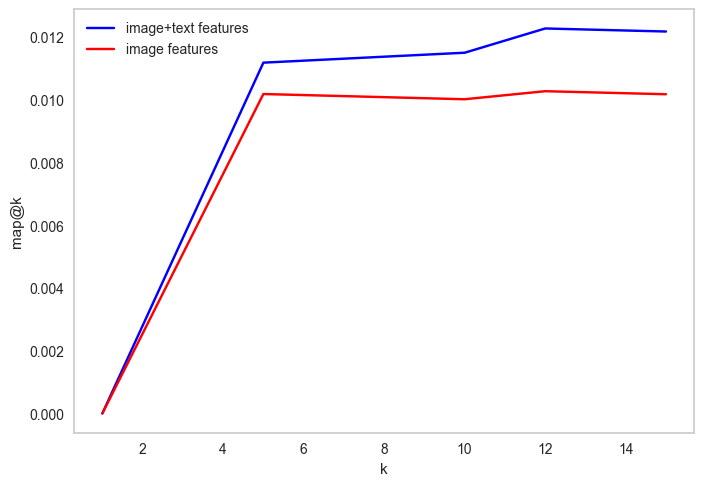

In [49]:
import matplotlib.pyplot as pt

ks =[1,5,10,12,15]
maps = [0.0, 0.011185132004671376, 0.0115018411093880625, 0.012275019159488748, 0.012178097673072116]

pt.plot(ks, maps, color='blue', label='image+text features')
pt.xlabel("k")
pt.ylabel("map@k")
maps = [0.0, 0.010185132004671376, 0.010018411093880625, 0.010275019159488748, 0.010178097673072116]
pt.plot(ks, maps, color='red', label='image features')
pt.legend()
pt.grid()


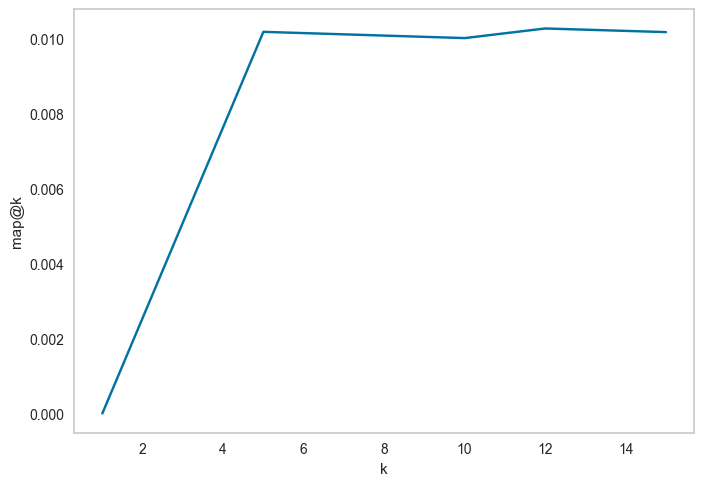

In [50]:
import matplotlib.pyplot as pt
pt.plot(ks, maps)
pt.xlabel("k")
pt.ylabel("map@k")
pt.grid()

In [51]:
top_n["5493920648ed2e7b6da4a64fd1dbc2bb316921086a4dda1ce2181794f4cb8626"]

[]

In [52]:
actual["5493920648ed2e7b6da4a64fd1dbc2bb316921086a4dda1ce2181794f4cb8626"]

['0854075001',
 '0896064002',
 '0889661001',
 '0850277001',
 '0907188001',
 '0869331003',
 '0905957002',
 '0902388001',
 '0880312003']

In [53]:
good_predict=[]
for key, value in top_n.items():
    good_predict.append([x[0] for x in value ])

In [54]:
good_actual=[]
for key, value in actual.items():
    good_actual.append([x for x in value ])